In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
from malaya_speech.torch_model.vits.model_infer import SynthesizerTrn
from malaya_boilerplate.train.config import HParams
import json

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


In [3]:
config = '/home/husein/dev/malaya-speech/malay_vits/multispeaker-clean.json'

In [4]:
with open(config) as fopen:
    hps = HParams(**json.load(fopen))

In [5]:
from malaya_speech.utils.text import TTS_SYMBOLS
import torch

In [6]:
model = SynthesizerTrn(len(TTS_SYMBOLS),
                                   hps.data.filter_length // 2 + 1,
                                   hps.train.segment_size // hps.data.hop_length,
                                   n_speakers=hps.data.n_speakers,
                                   **hps.model)

In [7]:
_ = model.eval()

In [8]:
!ls /home/husein/dev/malaya-speech/malay_vits/logs/multispeaker-clean/G_*.pth

/home/husein/dev/malaya-speech/malay_vits/logs/multispeaker-clean/G_490000.pth
/home/husein/dev/malaya-speech/malay_vits/logs/multispeaker-clean/G_495000.pth
/home/husein/dev/malaya-speech/malay_vits/logs/multispeaker-clean/G_500000.pth


In [9]:
pth = '/home/husein/dev/malaya-speech/malay_vits/logs/multispeaker-clean/G_500000.pth'

In [10]:
model.load_state_dict(torch.load(pth, map_location=torch.device('cpu'))['model'])

<All keys matched successfully>

In [11]:
from malaya_speech.torch_model.vits.commons import intersperse
import malaya_speech

In [12]:
normalizer = malaya_speech.utils.text.TextIDS(pad_to = None, is_lower = False)

In [13]:
text = 'Haqkiem adalah pelajar tahun akhir yang mengambil Ijazah Sarjana Muda Sains Komputer Kecerdasan Buatan utama dari Universiti Teknikal Malaysia Melaka (UTeM) .'

In [18]:
t, ids = normalizer.normalize(text)
ids = intersperse(ids, 0)
ids = torch.LongTensor(ids)
ids_lengths = torch.LongTensor([ids.size(0)])
ids = ids.unsqueeze(0)
audio = model.infer(
    ids,
    ids_lengths,
    noise_scale=0.,
    noise_scale_w=0.,
    length_scale=1.0,
    sid=torch.tensor([8]),
)

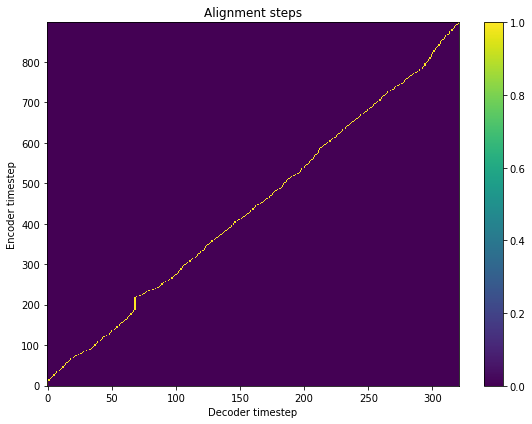

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    audio[1][0,0].detach().numpy(),
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [20]:
y = audio[0][0,0].detach().numpy()

In [21]:
import IPython.display as ipd
ipd.Audio(y, rate = 22050)

In [22]:
torch.save(model.state_dict(), 'multispeaker-clean.pth')

In [23]:
from malaya_boilerplate.huggingface import upload_dict

In [24]:
files_mapping = {'multispeaker-clean.pth': 'model.pth',
                config: 'config.json'}
upload_dict(model = 'VITS-multispeaker-clean', files_mapping = files_mapping, username = 'mesolitica')

/home/husein/.local/lib/python3.8/site-packages/huggingface_hub/hf_api.py:101: FutureWarning: `name` and `organization` input arguments are deprecated and will be removed in v0.10. Pass `repo_id` instead.
  warnings.warn(
<class 'requests.exceptions.HTTPError'> (Request ID: Root=1-64058970-08638a8807b512864506f2b3)

You already created this model repo - You already created this model repo
